In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import metpy.calc
from metpy.units import units

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split

from variable_names import to_keep

import warnings
warnings.filterwarnings('ignore')


In [2]:
# get data
df = pd.read_csv('data/Train.csv')

Next, one might want to get an overview what the data looks like, how large the DataFrame is and what it contains.

In [3]:
df.head()

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010Q650 X 2020-01-05,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,...,29.181258,-73.896588,30.545446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010Q650 X 2020-01-06,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,...,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df[to_keep]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 30 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Date                                                 30557 non-null  object 
 1   Place_ID                                             30557 non-null  object 
 2   target                                               30557 non-null  float64
 3   precipitable_water_entire_atmosphere                 30557 non-null  float64
 4   relative_humidity_2m_above_ground                    30557 non-null  float64
 5   specific_humidity_2m_above_ground                    30557 non-null  float64
 6   temperature_2m_above_ground                          30557 non-null  float64
 7   u_component_of_wind_10m_above_ground                 30557 non-null  float64
 8   v_component_of_wind_10m_above_ground                 30557 non-nul

<AxesSubplot:>

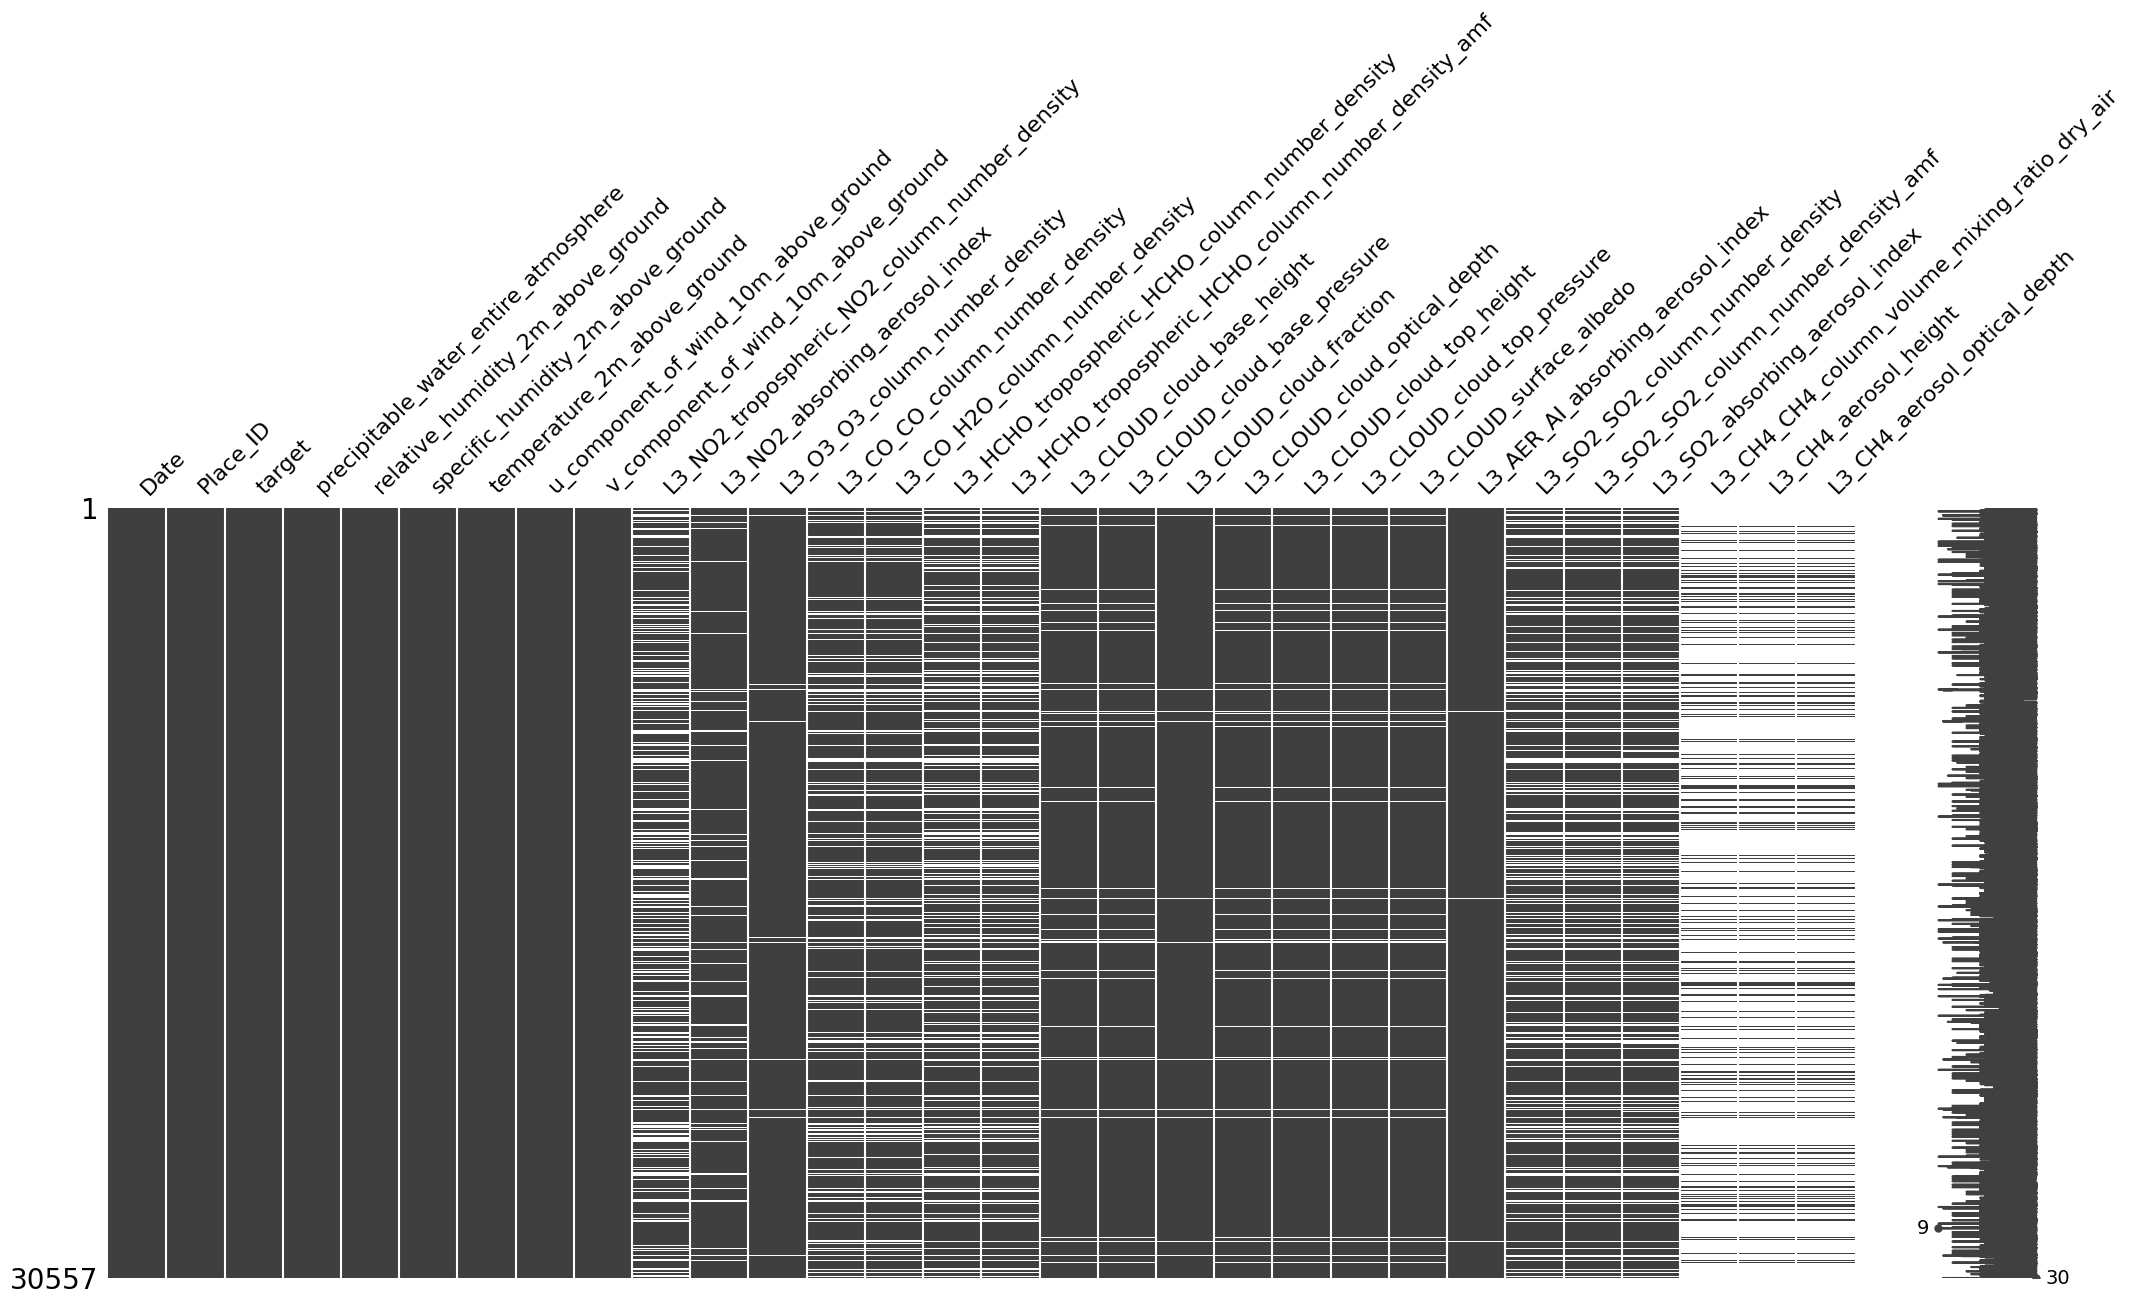

In [6]:
msno.matrix(df)

In [7]:
# calculate wind direction from components u and v
uwind = np.array(df['u_component_of_wind_10m_above_ground']) * units('m/s')
vwind = np.array(df['v_component_of_wind_10m_above_ground']) * units('m/s')

df['winddir'] = metpy.calc.wind_direction(uwind, vwind)
df['windspeed'] = metpy.calc.wind_speed(uwind, vwind)

In [8]:
df = df.drop('u_component_of_wind_10m_above_ground', axis=1)
df = df.drop('v_component_of_wind_10m_above_ground', axis=1)

In [9]:
# split data for first eda into three groups
df_met = df[['Date', 'Place_ID', 'target',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'winddir', 'windspeed']]
df_chem = df[['Place_ID', 'Date', 'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_NO2_absorbing_aerosol_index', 'L3_O3_O3_column_number_density',
       'L3_CO_CO_column_number_density', 'L3_CO_H2O_column_number_density',
       'L3_HCHO_tropospheric_HCHO_column_number_density',
       'L3_HCHO_tropospheric_HCHO_column_number_density_amf',
       'L3_SO2_SO2_column_number_density',
       'L3_SO2_SO2_column_number_density_amf',
       'L3_SO2_absorbing_aerosol_index',
       'L3_CH4_CH4_column_volume_mixing_ratio_dry_air',
       'L3_CH4_aerosol_height', 'L3_CH4_aerosol_optical_depth']]
df_cloud = df[['Place_ID', 'Date','L3_CLOUD_cloud_base_height', 'L3_CLOUD_cloud_base_pressure',
       'L3_CLOUD_cloud_fraction', 'L3_CLOUD_cloud_optical_depth',
       'L3_CLOUD_cloud_top_height', 'L3_CLOUD_cloud_top_pressure',
       'L3_CLOUD_surface_albedo', 'L3_AER_AI_absorbing_aerosol_index']]

In [10]:
df_met.describe()

,target,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,winddir,windspeed
count,30557.000000,30557.000000,30557.000000,30557.000000,30557.000000,30557.000000,30557.000000
mean,61.148045,15.302326,70.552747,0.006004,9.321342,182.879983,3.100731
std,46.861309,10.688573,18.807884,0.003787,9.343226,103.538992,2.209016
min,1.000000,0.420044,5.128572,0.000139,-34.647879,0.001644,0.020040
25%,25.000000,7.666667,58.600002,0.003403,3.123071,88.500396,1.497562
50%,50.000000,12.200000,74.099998,0.004912,8.478424,193.762182,2.545925
75%,80.000000,19.900000,85.450001,0.007562,16.201563,267.858060,4.152956
max,815.000000,72.599998,100.000000,0.021615,37.437921,359.980098,18.160623


In [11]:
df_chem.describe()

,L3_NO2_tropospheric_NO2_column_number_density,L3_NO2_absorbing_aerosol_index,L3_O3_O3_column_number_density,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_absorbing_aerosol_index,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth
count,21888.000000,28368.000000,30274.000000,25134.000000,25134.000000,23132.000000,23132.000000,23320.000000,23320.000000,23249.000000,5792.000000,5792.000000,5792.000000
mean,0.000056,-1.093982,0.139533,0.036230,983.448217,0.000088,1.064105,0.000113,0.429221,-1.944519,923.231949,1711.793613,0.016227
std,0.000075,0.610955,0.030511,0.010909,906.694162,0.000094,0.362690,0.000899,0.252026,0.707915,929.633988,1741.299304,0.027016
min,-0.000049,-3.941742,0.000000,0.000000,0.000000,-0.000630,0.000000,-0.038756,0.000000,-4.833706,0.000000,0.000000,0.000000
25%,0.000016,-1.514681,0.121587,0.031181,414.197452,0.000028,0.850102,-0.000107,0.251275,-2.372976,0.000000,0.000000,0.000000
50%,0.000035,-1.168333,0.140809,0.035563,713.649325,0.000076,1.011107,0.000056,0.377935,-1.963547,0.000000,0.000000,0.000000
75%,0.000070,-0.743363,0.157940,0.039797,1241.946035,0.000134,1.235345,0.000280,0.552592,-1.556129,1861.674119,3393.541633,0.023829
max,0.002055,4.824802,0.237652,0.291536,19656.359702,0.001015,3.099836,0.026994,2.184119,3.736877,2112.522949,6478.550544,0.210483


In [12]:
df_cloud.describe()

,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index
count,29035.000000,29035.000000,30183.000000,29035.000000,29035.000000,29035.000000,29035.000000,30360.000000
mean,2510.989311,77491.774334,0.433513,18.201564,3286.134009,70799.498221,0.226843,-1.161213
std,2244.918638,18369.734545,0.350953,23.790555,2410.281854,18595.820145,0.102019,0.538363
min,8.997803,12936.275870,0.000000,1.000000,10.049448,10956.609463,0.015649,-3.967332
25%,771.406343,65459.856331,0.112687,5.195713,1503.254367,57763.943781,0.167613,-1.517307
50%,1855.512628,81508.246961,0.340757,8.520578,2641.053220,74094.354412,0.210020,-1.179243
75%,3667.166162,92813.052502,0.771836,21.040006,4626.832633,85104.985144,0.258357,-0.817034
max,14000.000000,101299.000000,1.000000,237.121177,15000.000000,101299.000000,0.988804,4.824804


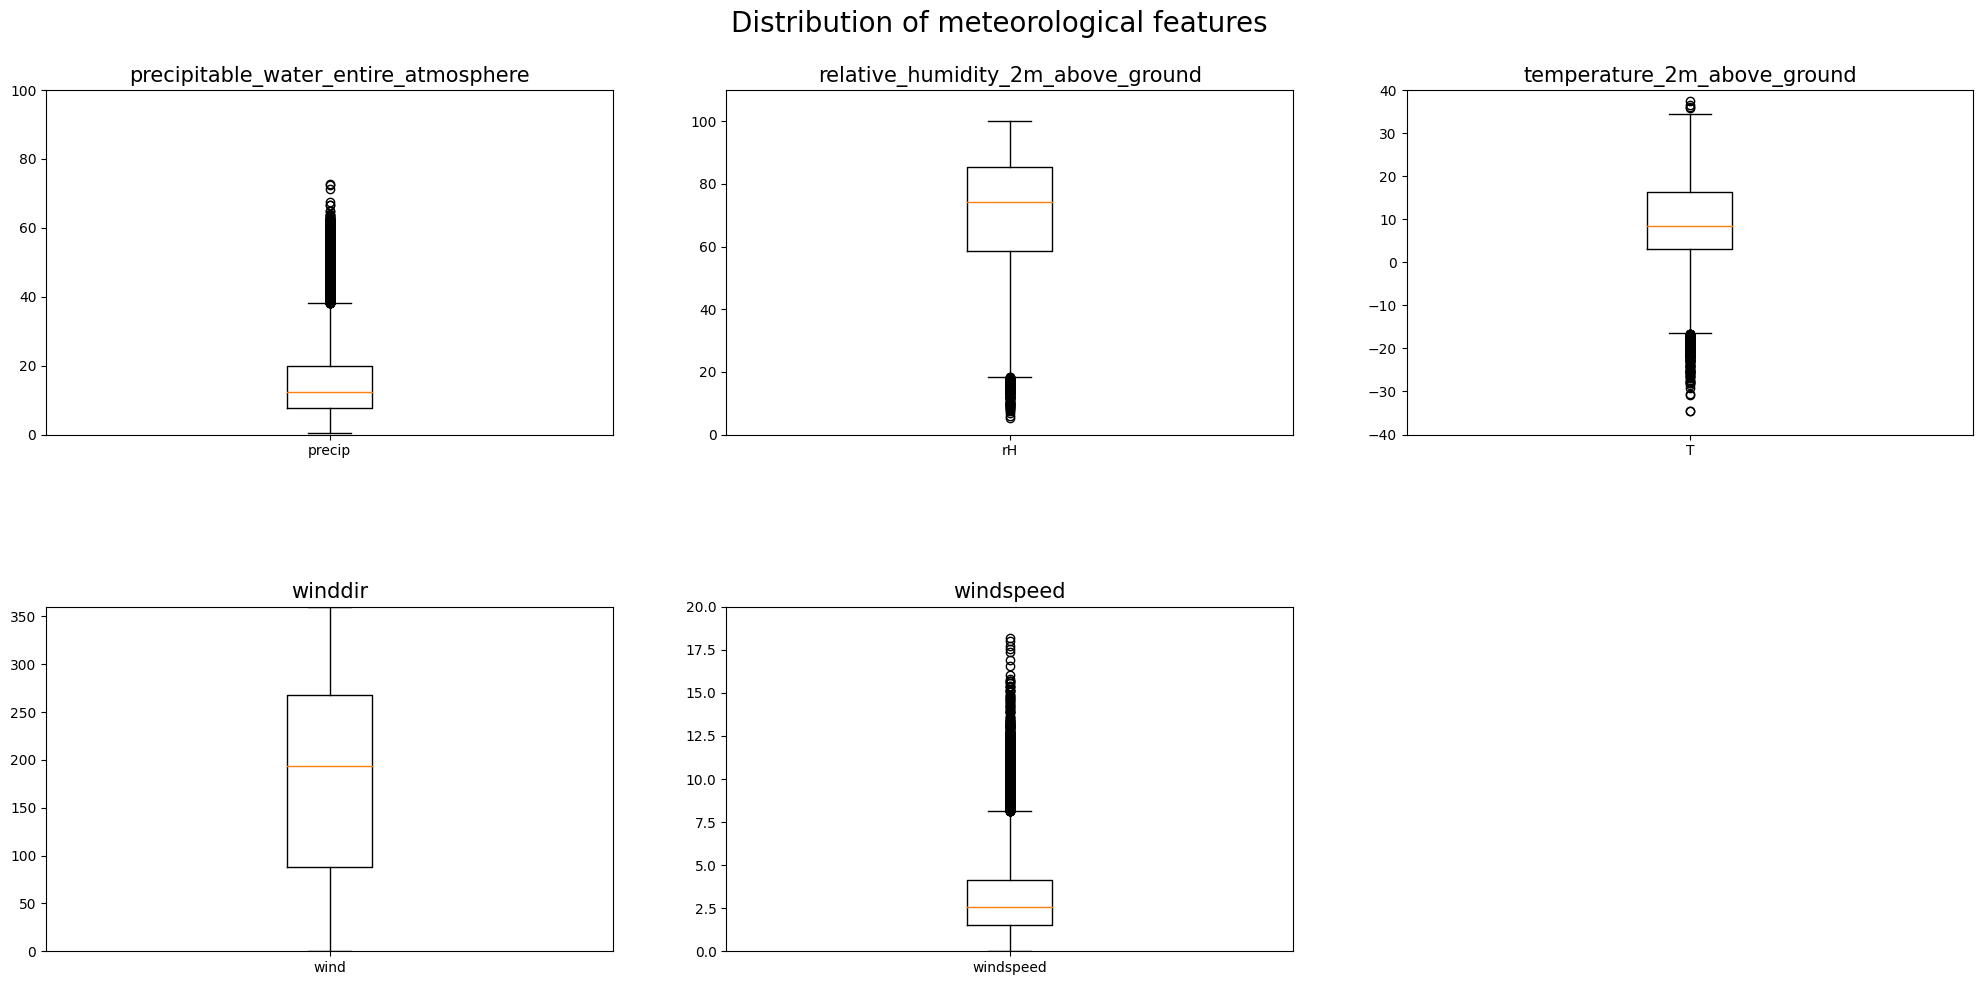

In [13]:
# plot meteorological variables distribution
fig, ax = plt.subplots(2,3, figsize=(20,10)) # create subplots on 2 rows and 3 columns
plt.suptitle('Distribution of meteorological features', fontsize=20)
fig.tight_layout() # tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area
plt.subplots_adjust(hspace = .5, wspace = .2, top = .9) # adjusts the space between the single subplots

ax[0][0].boxplot(x = df['precipitable_water_entire_atmosphere']) # creates boxplot for precipitable_water_entire_atmosphere
ax[0][0].set_xticklabels(labels=["precip"]) # sets the label for the ticks on the x-axis
ax[0][0].set_ylim(0,100) # limits the y-axis values 
ax[0][0].set_title("precipitable_water_entire_atmosphere", fontsize = 15); # sets title for subplot

ax[0][1].boxplot(x = df['relative_humidity_2m_above_ground'])
ax[0][1].set_xticklabels(labels=["rH"])
ax[0][1].set_ylim(0,110)
ax[0][1].set_title("relative_humidity_2m_above_ground", fontsize = 15);

ax[0][2].boxplot(x = df['temperature_2m_above_ground'])
ax[0][2].set_xticklabels(labels=["T"])
ax[0][2].set_ylim(-40,40)
ax[0][2].set_title("temperature_2m_above_ground", fontsize = 15);

ax[1][0].boxplot(x = df['winddir'])
ax[1][0].set_xticklabels(labels=["wind"])
ax[1][0].set_ylim(0,360)
ax[1][0].set_title("winddir", fontsize = 15);
                              
ax[1][1].boxplot(x = df['windspeed'])
ax[1][1].set_xticklabels(labels=["windspeed"])
ax[1][1].set_ylim(0,20)
ax[1][1].set_title("windspeed", fontsize = 15);

fig.delaxes(ax[1][2]);

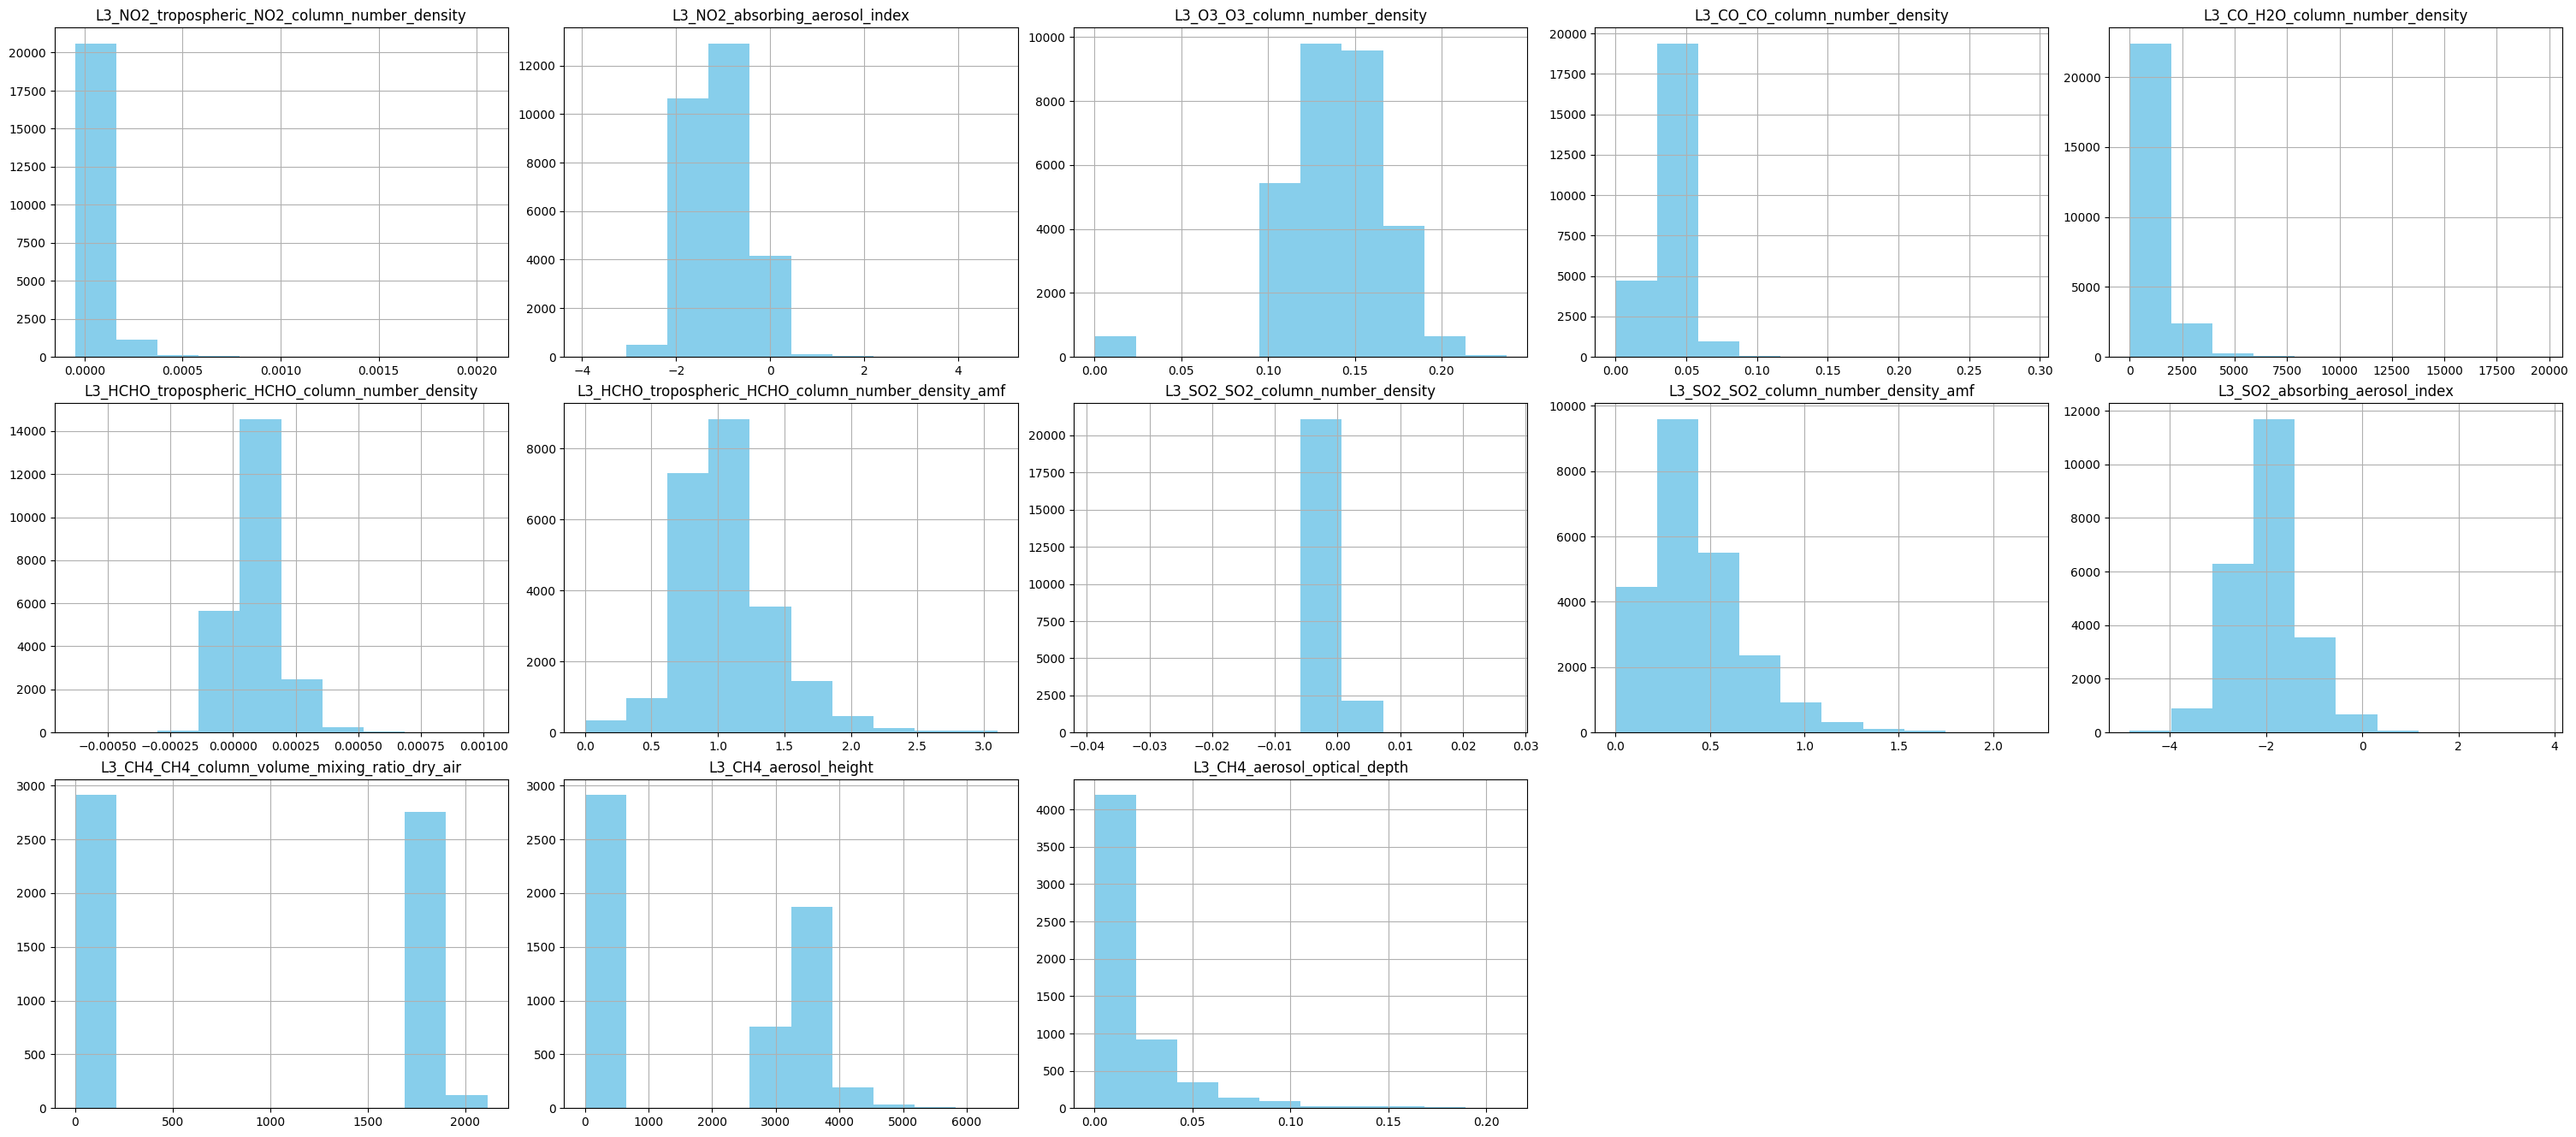

In [14]:
# plot chemical features histograms
fig = plt.figure(constrained_layout = True) 
fig.set_figheight(80)
fig.set_figwidth(30)
plt.suptitle('Distribution of chemical features', fontsize=20)

ax = fig.gca()
df_chem.hist(ax=ax, color = "skyblue",layout=(20,5))
plt.show()

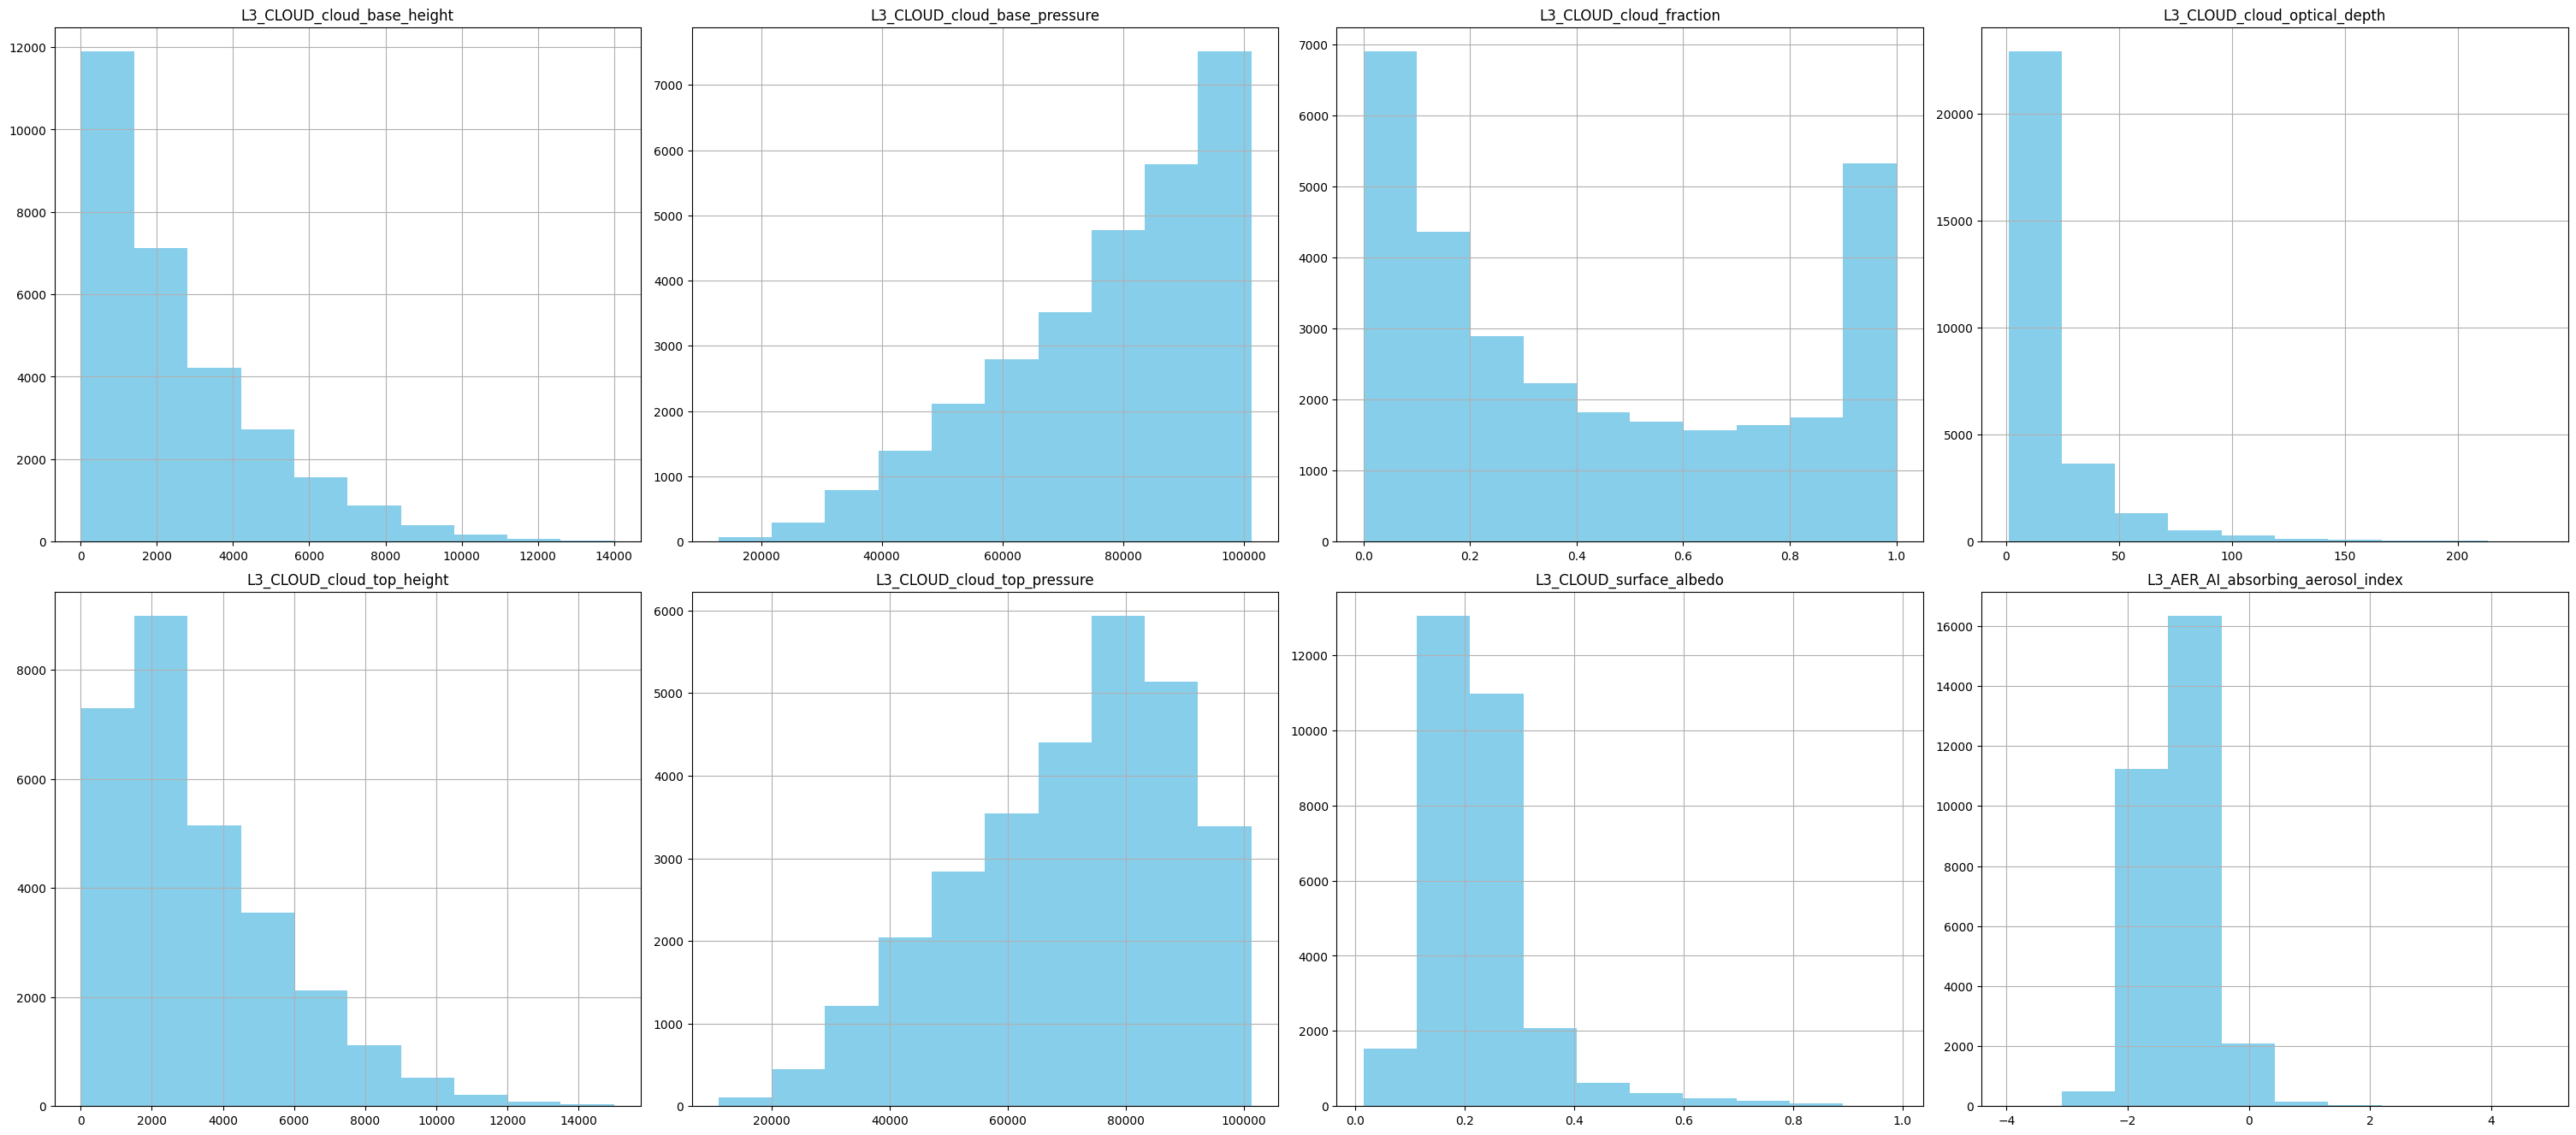

In [15]:
# plot cloud features histograms
fig = plt.figure(constrained_layout = True) 
fig.set_figheight(50)
fig.set_figwidth(30)
plt.suptitle('Distribution of cloud features', fontsize=20)

ax = fig.gca()
df_cloud.hist(ax=ax, color = "skyblue",layout=(8,4))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

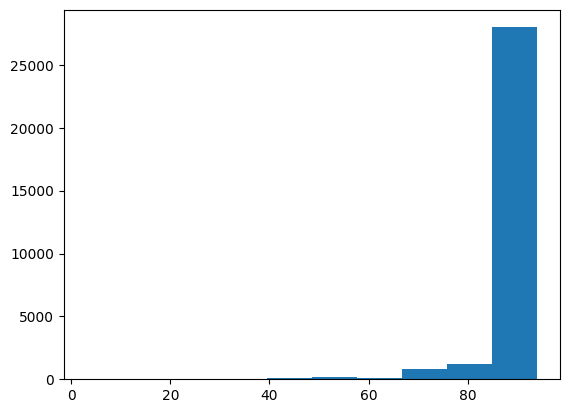

In [16]:
# how many days of data for each location is given
df['placeID_freq'] = df['Place_ID'].map(df['Place_ID'].value_counts())
plt.hist(df.placeID_freq)
plt.show

In [17]:
# number of unique locations
df.Place_ID.nunique()

340

In [18]:
# group by locations (340 individuals)
place_group = df.groupby('Place_ID')

In [19]:
place_group.mean()

,target,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,L3_NO2_tropospheric_NO2_column_number_density,L3_NO2_absorbing_aerosol_index,L3_O3_O3_column_number_density,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,...,L3_AER_AI_absorbing_aerosol_index,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_absorbing_aerosol_index,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,winddir,windspeed,placeID_freq
Place_ID,,,,,,,,,,,,,,,,,,,,,
010Q650,37.063830,14.274552,41.067022,0.005980,20.483771,0.000015,-0.718028,0.117041,0.023900,1048.681113,...,-0.810368,0.000036,0.427888,-1.296942,1093.724798,1963.473195,0.008459,256.735870,3.079596,94.0
05EC30X,39.322222,21.277033,59.338890,0.008652,17.667414,0.000013,-1.202101,0.116305,0.022203,1794.585984,...,-1.298696,0.000031,0.643256,-2.035350,952.423624,1696.267910,0.012997,131.563476,3.590734,90.0
0DPWHX8,79.904255,12.583063,80.236172,0.004659,5.891324,0.000054,-1.166821,0.155016,0.034855,682.629557,...,-1.231106,0.000087,0.318742,-2.235594,928.674786,1654.370821,0.007865,226.206233,1.874034,94.0
0GBXTHY,16.329787,8.708063,76.943618,0.003248,0.968610,0.000013,-1.067378,0.165530,0.035333,421.118971,...,-1.123056,-0.000376,0.219194,-2.074838,0.000000,0.000000,0.000000,192.600822,4.813148,94.0
0HYPV1N,87.946809,37.563914,73.253193,0.015716,26.330684,0.000041,-1.315086,0.111732,0.048876,2844.918340,...,-1.463452,-0.000046,0.593761,-1.899027,0.000000,0.000000,0.000000,119.140817,1.967982,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YLLOKEY,27.510638,12.185545,88.240782,0.004738,4.573380,0.000039,-1.082273,0.154705,0.034733,695.784326,...,-1.073499,0.000384,0.287544,-2.125361,468.765880,885.726126,0.004657,207.407621,4.751079,94.0
YLZOBFW,22.744681,5.360722,81.867023,0.002522,-5.600486,0.000049,-1.057472,0.165919,0.030641,262.410983,...,-1.163832,-0.000128,0.566132,-2.170550,657.084420,1319.903393,0.019040,177.133408,2.710797,94.0
YPXSK14,125.223404,7.073488,84.644895,0.003378,-1.242976,0.000040,-1.072226,0.152990,0.032015,432.690130,...,-1.183153,0.000252,0.262254,-2.056592,185.775244,311.475757,0.001174,145.160691,2.183918,94.0


In [20]:
df.Date

0        2020-01-02
1        2020-01-03
2        2020-01-04
3        2020-01-05
4        2020-01-06
            ...    
30552    2020-03-15
30553    2020-03-16
30554    2020-03-17
30555    2020-03-18
30556    2020-03-19
Name: Date, Length: 30557, dtype: object

In [21]:
# column weekday
# convert to pd datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')


In [22]:
df['weekday'] = df.Date.dt.dayofweek # Monday = 0

In [23]:
df.weekday

0        3
1        4
2        5
3        6
4        0
        ..
30552    6
30553    0
30554    1
30555    2
30556    3
Name: weekday, Length: 30557, dtype: int64